# Imports and Data Loading

**Experiment**: <br>
1. Inputs : Min, max, Qty, modal at time t-0
2. Output : modal_price from t+1 to t+5
3. Models : Stacked Bi-Dir LSTM.
4. Hyperparameter tuning


In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Dropout

In [2]:
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import tensorflow as tf

In [5]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [6]:
pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from scikeras.wrappers import KerasRegressor

In [8]:
from google.colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [9]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
#df_tomato = pd.read_excel('Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [10]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [11]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [12]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [13]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [14]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [15]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

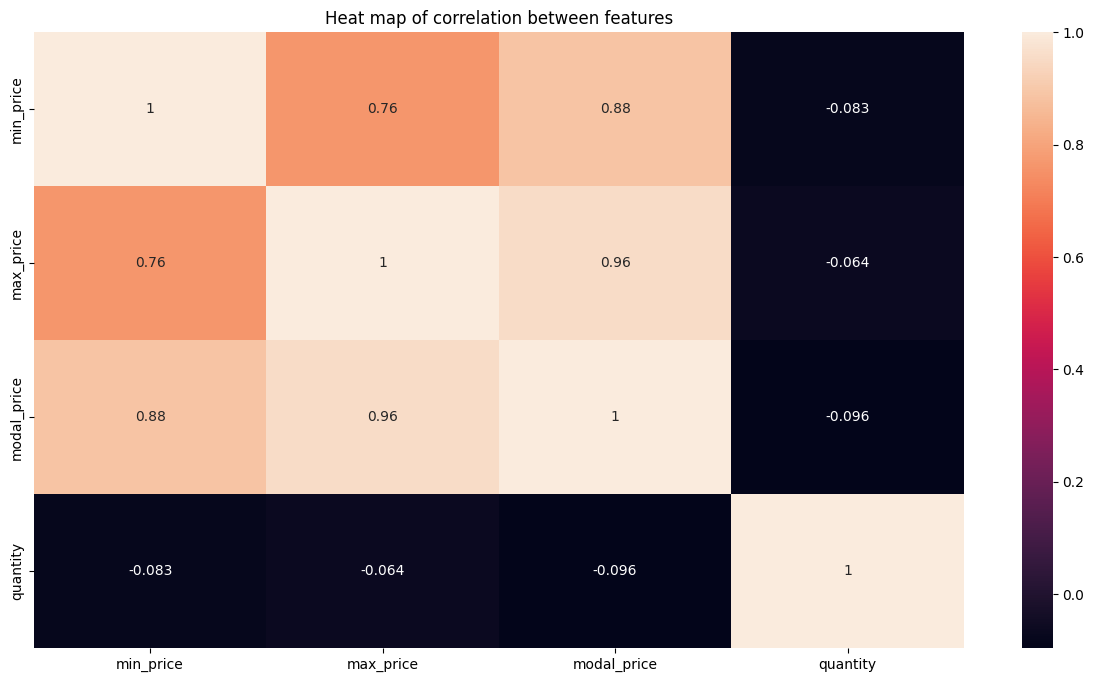

In [16]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [17]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [18]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [19]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,quantity,min_price,max_price,modal_price
arrival_date,,,,
2020-01-01,4144,333,1467,733
2020-01-02,4430,333,1733,986
2020-01-03,4532,400,2000,1047
2020-01-04,5578,333,2000,1033
2020-01-05,4960,333,2000,1033


# Preparing the dataset for training

### Creating Feature variable

In [20]:
# Function to create as many as features to represent the window size
#def createWindow(winSize):
#  df_temp = pd.DataFrame()
#  for i in range(0,winSize):
#    df_temp["feature_t"+str(i+1)] = df_tomato_3['modal_price'].shift(-i)
#  return df_temp

In [21]:
# Generating new features
#df_newCols = createWindow(35)
#df_newCols.head()

In [22]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

In [23]:
# Replacing null values with 0, thus created window of 30 days as each input.
#for val in df_tomato_4.columns:
#  df_tomato_4[val].fillna(0, inplace=True)
#df_tomato_4.head()

In [24]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [25]:
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [26]:
# Generating new features
df_newCols = createWindow(5)
df_newCols.head()

,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [27]:
# joining with base dataframe
df_tomato_4 = df_tomato_3.join(df_newCols)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,
2020-01-01,4144,333,1467,733,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1046.0,1153.0,933.0,1133.0,933.0


In [28]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,quantity,min_price,max_price,modal_price,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,
2020-01-01,4144,333,1467,733,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...
2023-03-09,2874,400,1800,1000,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,3506,530,2000,1270,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,3698,400,1870,1200,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [29]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,quantity,min_price,max_price,modal_price,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,
2020-01-01,0.076304,0.068107,0.129021,0.091897,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.083274,0.068107,0.161185,0.135517,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.085760,0.085133,0.193470,0.146034,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.111252,0.068107,0.193470,0.143621,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.096191,0.068107,0.193470,0.143621,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [30]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [31]:
# Creating Training dataset
train_X = pd.DataFrame(index=train_data.index)
train_y = pd.DataFrame(index=train_data.index)
for i in train_data.columns:
  if i.startswith('target'):
    train_y[i] = train_data[i]
  else:
    train_X[i] = train_data[i]

In [32]:
# Creating Testing dataset
test_X = pd.DataFrame(index=test_data.index)
test_y = pd.DataFrame(index=test_data.index)
for i in test_data.columns:
  if i.startswith('target'):
    test_y[i] = test_data[i]
  else:
    test_X[i] = test_data[i]

In [33]:
# Splitting target and feature variables
#train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

#test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [34]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [35]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((int(train_X.shape[0]), 1, train_X.shape[1]))
vec_test_X = vec_test_X.reshape((int(test_X.shape[0]), 1, test_X.shape[1]))

In [36]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 1, 4) (926, 5) (232, 1, 4) (232, 5)


In [37]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# Model - Stacked Bi-Dir LSTM

## Model building

In [38]:
# Function to create model, required for KerasClassifier
def create_model():
  # create model
  model_Stacked_biDir = Sequential()
  model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                        input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
  model_Stacked_biDir.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
  model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu')))
  model_Stacked_biDir.add(Dropout(0.2))
  model_Stacked_biDir.add(Dense(vec_train_y.shape[1]))
  # Compile model
  model_Stacked_biDir.compile(optimizer='adam', loss='mae', metrics=['mean_absolute_error'])
  return model_Stacked_biDir

In [39]:
calls=[
    EarlyStopping(monitor='mae', patience=10), 
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks', monitor='mae', save_best_only=True, mode='auto', save_freq=1)
    ]

In [40]:
# create model
lstm_regressor = KerasRegressor(model=create_model, callbacks=calls)

## Hyperparameter Tuning - Batch Size

### Selecting the Batch size

In [ ]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [50, 100, 250, 500, 1000]
epoch_values = [100] #[100, 250, 500]
lr_values = [0.01] #[0.001, 0.01, 0.1, 0.2, 0.3]
momentum_values = [0.2] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [ ]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 15s - loss: 0.1857 - mean_absolute_error: 0.1857

4/4 [==============================] - ETA: 0s - loss: 0.1675 - mean_absolute_error: 0.1675 

4/4 [==============================] - 6s 343ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.1390 - val_mean_absolute_error: 0.1390
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1698 - mean_absolute_error: 0.1698

3/4 [=====================>........] - ETA: 0s - loss: 0.1575 - mean_absolute_error: 0.1575

4/4 [==============================] - 0s 54ms/step - loss: 0.1586 - mean_absolute_error: 0.1586 - val_loss: 0.1298 - val_mean_absolute_error: 0.1298
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1523 - mean_absolute_error: 0.1523

3/4 [=====================>........] - ETA: 0s - loss: 0.1526 - mean_absolute_error: 0.1526

4/4 [==============================] - 0s 49ms/step - loss: 0.1488 - mean_absolute_error: 0.1488 - val_loss: 0.1191 - val_mean_absolute_error: 0.1191
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1472 - mean_absolute_error: 0.1472

3/4 [=====================>........] - ETA: 0s - loss: 0.1396 - mean_absolute_error: 0.1396

4/4 [==============================] - 0s 45ms/step - loss: 0.1377 - mean_absolute_error: 0.1377 - val_loss: 0.1067 - val_mean_absolute_error: 0.1067
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1384 - mean_absolute_error: 0.1384

3/4 [=====================>........] - ETA: 0s - loss: 0.1257 - mean_absolute_error: 0.1257

4/4 [==============================] - 0s 52ms/step - loss: 0.1268 - mean_absolute_error: 0.1268 - val_loss: 0.0929 - val_mean_absolute_error: 0.0929
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1180 - mean_absolute_error: 0.1180

3/4 [=====================>........] - ETA: 0s - loss: 0.1188 - mean_absolute_error: 0.1188

4/4 [==============================] - 0s 44ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.0790 - val_mean_absolute_error: 0.0790
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1101 - mean_absolute_error: 0.1101

3/4 [=====================>........] - ETA: 0s - loss: 0.1110 - mean_absolute_error: 0.1110

4/4 [==============================] - 0s 59ms/step - loss: 0.1091 - mean_absolute_error: 0.1091 - val_loss: 0.0676 - val_mean_absolute_error: 0.0676
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1005 - mean_absolute_error: 0.1005

3/4 [=====================>........] - ETA: 0s - loss: 0.1044 - mean_absolute_error: 0.1044

4/4 [==============================] - 0s 48ms/step - loss: 0.1033 - mean_absolute_error: 0.1033 - val_loss: 0.0593 - val_mean_absolute_error: 0.0593
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1003 - mean_absolute_error: 0.1003

3/4 [=====================>........] - ETA: 0s - loss: 0.0991 - mean_absolute_error: 0.0991

4/4 [==============================] - 0s 54ms/step - loss: 0.0999 - mean_absolute_error: 0.0999 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1025 - mean_absolute_error: 0.1025

3/4 [=====================>........] - ETA: 0s - loss: 0.0952 - mean_absolute_error: 0.0952

4/4 [==============================] - 0s 55ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0994 - mean_absolute_error: 0.0994

3/4 [=====================>........] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.0926

4/4 [==============================] - 0s 53ms/step - loss: 0.0924 - mean_absolute_error: 0.0924 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.0993

3/4 [=====================>........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.0886

4/4 [==============================] - 0s 43ms/step - loss: 0.0891 - mean_absolute_error: 0.0891 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0854 - mean_absolute_error: 0.0854

3/4 [=====================>........] - ETA: 0s - loss: 0.0846 - mean_absolute_error: 0.0846

4/4 [==============================] - 0s 51ms/step - loss: 0.0857 - mean_absolute_error: 0.0857 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0836 - mean_absolute_error: 0.0836

3/4 [=====================>........] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.0791

4/4 [==============================] - 0s 44ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.0755

3/4 [=====================>........] - ETA: 0s - loss: 0.0758 - mean_absolute_error: 0.0758

4/4 [==============================] - 0s 51ms/step - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0768 - mean_absolute_error: 0.0768

3/4 [=====================>........] - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.0717

4/4 [==============================] - 0s 47ms/step - loss: 0.0704 - mean_absolute_error: 0.0704 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.0673

3/4 [=====================>........] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.0628

4/4 [==============================] - 0s 49ms/step - loss: 0.0640 - mean_absolute_error: 0.0640 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.0611

3/4 [=====================>........] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.0587

4/4 [==============================] - 0s 55ms/step - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.0533

3/4 [=====================>........] - ETA: 0s - loss: 0.0525 - mean_absolute_error: 0.0525

4/4 [==============================] - 0s 49ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0519 - mean_absolute_error: 0.0519

3/4 [=====================>........] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.0482

4/4 [==============================] - 0s 56ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.0454

3/4 [=====================>........] - ETA: 0s - loss: 0.0433 - mean_absolute_error: 0.0433

4/4 [==============================] - 0s 57ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

3/4 [=====================>........] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.0438

4/4 [==============================] - 0s 56ms/step - loss: 0.0438 - mean_absolute_error: 0.0438 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.0425

3/4 [=====================>........] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.0454

4/4 [==============================] - 0s 46ms/step - loss: 0.0436 - mean_absolute_error: 0.0436 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

3/4 [=====================>........] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

4/4 [==============================] - 0s 53ms/step - loss: 0.0422 - mean_absolute_error: 0.0422 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421

3/4 [=====================>........] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410

4/4 [==============================] - 0s 50ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0433 - mean_absolute_error: 0.0433

3/4 [=====================>........] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410

4/4 [==============================] - 0s 52ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

4/4 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - 0s 34ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.0396

4/4 [==============================] - 0s 39ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

4/4 [==============================] - 0s 37ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 35ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

4/4 [==============================] - 0s 43ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 33ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429

4/4 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

4/4 [==============================] - 0s 37ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 35ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 35ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 36ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 36ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

3/4 [=====================>........] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 38ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 34ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 36ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 39ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 37ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 38ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 31ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 0s 35ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 38ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 33ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 37ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 35ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 38ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 37ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 37ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 38ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 36ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 35ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 35ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 38ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 37ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 43ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 37ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 39ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 40ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 37ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 37ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 40ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 38ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 40ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 44ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 34ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 39ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 36ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 36ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.0327

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 36ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 42ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 37ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 39ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 45ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 35ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 35ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 42ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 36ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 46ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 37ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 36ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 45ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 41ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0318

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 42ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 35ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 41ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 42ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 40ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 46ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - 0s 43ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 48ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 42ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 46ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 53ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.0417

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 66ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 53ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

4/4 [==============================] - 0s 56ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280


### Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.800396 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.737731 (0.123129) with: {'batch_size': 50, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.787821 (0.067855) with: {'batch_size': 100, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.800396 (0.059995) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.771023 (0.073246) with: {'batch_size': 500, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.625753 (0.172326) with: {'batch_size': 1000, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}


**Inference** Best Batch Size : 250

## Hyperparameter Tuning - Learning Rate

### Selecting the Learning Rate

In [ ]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500]
lr_values = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum_values = [0.2] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [ ]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 21s - loss: 0.1855 - mean_absolute_error: 0.1855

4/4 [==============================] - ETA: 0s - loss: 0.1673 - mean_absolute_error: 0.1673 

4/4 [==============================] - 8s 256ms/step - loss: 0.1673 - mean_absolute_error: 0.1673 - val_loss: 0.1388 - val_mean_absolute_error: 0.1388
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.1696

3/4 [=====================>........] - ETA: 0s - loss: 0.1573 - mean_absolute_error: 0.1573

4/4 [==============================] - 0s 83ms/step - loss: 0.1584 - mean_absolute_error: 0.1584 - val_loss: 0.1293 - val_mean_absolute_error: 0.1293
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1521 - mean_absolute_error: 0.1521

3/4 [=====================>........] - ETA: 0s - loss: 0.1524 - mean_absolute_error: 0.1524

4/4 [==============================] - 0s 112ms/step - loss: 0.1485 - mean_absolute_error: 0.1485 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1469 - mean_absolute_error: 0.1469

3/4 [=====================>........] - ETA: 0s - loss: 0.1394 - mean_absolute_error: 0.1394

4/4 [==============================] - 0s 87ms/step - loss: 0.1375 - mean_absolute_error: 0.1375 - val_loss: 0.1061 - val_mean_absolute_error: 0.1061
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1381 - mean_absolute_error: 0.1381

4/4 [==============================] - 0s 29ms/step - loss: 0.1263 - mean_absolute_error: 0.1263 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1169 - mean_absolute_error: 0.1169

4/4 [==============================] - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.1160

4/4 [==============================] - 0s 30ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1097 - mean_absolute_error: 0.1097

4/4 [==============================] - ETA: 0s - loss: 0.1081 - mean_absolute_error: 0.1081

4/4 [==============================] - 0s 30ms/step - loss: 0.1081 - mean_absolute_error: 0.1081 - val_loss: 0.0657 - val_mean_absolute_error: 0.0657
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.1001

4/4 [==============================] - ETA: 0s - loss: 0.1024 - mean_absolute_error: 0.1024

4/4 [==============================] - 0s 77ms/step - loss: 0.1024 - mean_absolute_error: 0.1024 - val_loss: 0.0567 - val_mean_absolute_error: 0.0567
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0984 - mean_absolute_error: 0.0984

2/4 [==============>...............] - ETA: 0s - loss: 0.0981 - mean_absolute_error: 0.0981

4/4 [==============================] - ETA: 0s - loss: 0.0981 - mean_absolute_error: 0.0981

4/4 [==============================] - 0s 58ms/step - loss: 0.0981 - mean_absolute_error: 0.0981 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1005 - mean_absolute_error: 0.1005

2/4 [==============>...............] - ETA: 0s - loss: 0.0945 - mean_absolute_error: 0.0945

4/4 [==============================] - ETA: 0s - loss: 0.0937 - mean_absolute_error: 0.0937

4/4 [==============================] - 0s 98ms/step - loss: 0.0937 - mean_absolute_error: 0.0937 - val_loss: 0.0478 - val_mean_absolute_error: 0.0478
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0973 - mean_absolute_error: 0.0973

2/4 [==============>...............] - ETA: 0s - loss: 0.0920 - mean_absolute_error: 0.0920

4/4 [==============================] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.0899

4/4 [==============================] - 0s 62ms/step - loss: 0.0899 - mean_absolute_error: 0.0899 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0962 - mean_absolute_error: 0.0962

4/4 [==============================] - ETA: 0s - loss: 0.0867 - mean_absolute_error: 0.0867

4/4 [==============================] - 0s 32ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0831 - mean_absolute_error: 0.0831

4/4 [==============================] - ETA: 0s - loss: 0.0835 - mean_absolute_error: 0.0835

4/4 [==============================] - 0s 40ms/step - loss: 0.0835 - mean_absolute_error: 0.0835 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0812 - mean_absolute_error: 0.0812

3/4 [=====================>........] - ETA: 0s - loss: 0.0768 - mean_absolute_error: 0.0768

4/4 [==============================] - 0s 38ms/step - loss: 0.0781 - mean_absolute_error: 0.0781 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.0719

4/4 [==============================] - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.0724

4/4 [==============================] - 0s 39ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0731 - mean_absolute_error: 0.0731

4/4 [==============================] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.0670

4/4 [==============================] - 0s 33ms/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.0642

3/4 [=====================>........] - ETA: 0s - loss: 0.0602 - mean_absolute_error: 0.0602

4/4 [==============================] - 0s 41ms/step - loss: 0.0612 - mean_absolute_error: 0.0612 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.0595

4/4 [==============================] - ETA: 0s - loss: 0.0546 - mean_absolute_error: 0.0546

4/4 [==============================] - 0s 36ms/step - loss: 0.0546 - mean_absolute_error: 0.0546 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0494 - mean_absolute_error: 0.0494

4/4 [==============================] - ETA: 0s - loss: 0.0498 - mean_absolute_error: 0.0498

4/4 [==============================] - 0s 32ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0507 - mean_absolute_error: 0.0507

4/4 [==============================] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.0452

4/4 [==============================] - 0s 34ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.0454

3/4 [=====================>........] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

4/4 [==============================] - 0s 47ms/step - loss: 0.0433 - mean_absolute_error: 0.0433 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

3/4 [=====================>........] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

4/4 [==============================] - 0s 43ms/step - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.0418

4/4 [==============================] - ETA: 0s - loss: 0.0433 - mean_absolute_error: 0.0433

4/4 [==============================] - 0s 42ms/step - loss: 0.0433 - mean_absolute_error: 0.0433 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.0418

4/4 [==============================] - 0s 32ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

4/4 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.0405

4/4 [==============================] - 0s 34ms/step - loss: 0.0405 - mean_absolute_error: 0.0405 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419

4/4 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - 0s 38ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

4/4 [==============================] - 0s 40ms/step - loss: 0.0400 - mean_absolute_error: 0.0400 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - 0s 36ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - 0s 40ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 34ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

4/4 [==============================] - 0s 40ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 34ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 35ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

3/4 [=====================>........] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 43ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 33ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 41ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 36ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 37ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 37ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 38ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 41ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.0420

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 43ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 53ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 52ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 53ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 50ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

3/4 [=====================>........] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 53ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 54ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 0s 53ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 52ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 46ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 52ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 54ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 59ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 51ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 54ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 48ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 48ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 60ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 46ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

3/4 [=====================>........] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 52ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 49ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

2/4 [==============>...............] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 63ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

3/4 [=====================>........] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 63ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 53ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 56ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 55ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 55ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 61ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 53ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 51ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 60ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 55ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 56ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 49ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 43ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 48ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 45ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 39ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 38ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 47ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 40ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 43ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 38ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 48ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 37ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 41ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 40ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 43ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 41ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333

4/4 [==============================] - 0s 47ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 42ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - 0s 40ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 44ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 43ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

3/4 [=====================>........] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

4/4 [==============================] - 0s 39ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 42ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 44ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 40ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

4/4 [==============================] - 0s 43ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278


### Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.809966 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.802168 (0.057333) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.807425 (0.054132) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.799701 (0.057862) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.1, 'optimizer__momentum': 0.2}
0.800701 (0.056859) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.2, 'optimizer__momentum': 0.2}
0.809966 (0.051537) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}


**Inference** Best Learning Rate 0.3

## Hyperparameter Tuning - Momentum

### Hyperparameter Tuning 

In [ ]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500]
lr_values = [0.3] #[0.001, 0.01, 0.1, 0.2, 0.3] --> Phase 2 result, best Learning Rate 0.3
momentum_values = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [ ]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 18s - loss: 0.1864 - mean_absolute_error: 0.1864

3/4 [=====================>........] - ETA: 0s - loss: 0.1683 - mean_absolute_error: 0.1683 

4/4 [==============================] - 7s 388ms/step - loss: 0.1683 - mean_absolute_error: 0.1683 - val_loss: 0.1399 - val_mean_absolute_error: 0.1399
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1709 - mean_absolute_error: 0.1709

3/4 [=====================>........] - ETA: 0s - loss: 0.1587 - mean_absolute_error: 0.1587

4/4 [==============================] - 0s 53ms/step - loss: 0.1598 - mean_absolute_error: 0.1598 - val_loss: 0.1311 - val_mean_absolute_error: 0.1311
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1538 - mean_absolute_error: 0.1538

3/4 [=====================>........] - ETA: 0s - loss: 0.1544 - mean_absolute_error: 0.1544

4/4 [==============================] - 0s 52ms/step - loss: 0.1506 - mean_absolute_error: 0.1506 - val_loss: 0.1211 - val_mean_absolute_error: 0.1211
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1494 - mean_absolute_error: 0.1494

3/4 [=====================>........] - ETA: 0s - loss: 0.1420 - mean_absolute_error: 0.1420

4/4 [==============================] - 0s 59ms/step - loss: 0.1402 - mean_absolute_error: 0.1402 - val_loss: 0.1096 - val_mean_absolute_error: 0.1096
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1411 - mean_absolute_error: 0.1411

3/4 [=====================>........] - ETA: 0s - loss: 0.1283 - mean_absolute_error: 0.1283

4/4 [==============================] - 0s 54ms/step - loss: 0.1295 - mean_absolute_error: 0.1295 - val_loss: 0.0967 - val_mean_absolute_error: 0.0967
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1207 - mean_absolute_error: 0.1207

3/4 [=====================>........] - ETA: 0s - loss: 0.1215 - mean_absolute_error: 0.1215

4/4 [==============================] - 0s 54ms/step - loss: 0.1194 - mean_absolute_error: 0.1194 - val_loss: 0.0831 - val_mean_absolute_error: 0.0831
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1128 - mean_absolute_error: 0.1128

3/4 [=====================>........] - ETA: 0s - loss: 0.1131 - mean_absolute_error: 0.1131

4/4 [==============================] - 0s 55ms/step - loss: 0.1111 - mean_absolute_error: 0.1111 - val_loss: 0.0712 - val_mean_absolute_error: 0.0712
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1017 - mean_absolute_error: 0.1017

3/4 [=====================>........] - ETA: 0s - loss: 0.1062 - mean_absolute_error: 0.1062

4/4 [==============================] - 0s 57ms/step - loss: 0.1050 - mean_absolute_error: 0.1050 - val_loss: 0.0618 - val_mean_absolute_error: 0.0618
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1003 - mean_absolute_error: 0.1003

3/4 [=====================>........] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.0998

4/4 [==============================] - 0s 50ms/step - loss: 0.1007 - mean_absolute_error: 0.1007 - val_loss: 0.0553 - val_mean_absolute_error: 0.0553
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1032 - mean_absolute_error: 0.1032

4/4 [==============================] - ETA: 0s - loss: 0.0966 - mean_absolute_error: 0.0966

4/4 [==============================] - 0s 34ms/step - loss: 0.0966 - mean_absolute_error: 0.0966 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0989 - mean_absolute_error: 0.0989

4/4 [==============================] - ETA: 0s - loss: 0.0924 - mean_absolute_error: 0.0924

4/4 [==============================] - 0s 38ms/step - loss: 0.0924 - mean_absolute_error: 0.0924 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1006 - mean_absolute_error: 0.1006

4/4 [==============================] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.0896

4/4 [==============================] - 0s 37ms/step - loss: 0.0896 - mean_absolute_error: 0.0896 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0844 - mean_absolute_error: 0.0844

4/4 [==============================] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.0862

4/4 [==============================] - 0s 39ms/step - loss: 0.0862 - mean_absolute_error: 0.0862 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0841 - mean_absolute_error: 0.0841

4/4 [==============================] - ETA: 0s - loss: 0.0813 - mean_absolute_error: 0.0813

4/4 [==============================] - 0s 40ms/step - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.0773

4/4 [==============================] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.0773

4/4 [==============================] - 0s 37ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0419 - val_mean_absolute_error: 0.0419
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0786 - mean_absolute_error: 0.0786

4/4 [==============================] - ETA: 0s - loss: 0.0722 - mean_absolute_error: 0.0722

4/4 [==============================] - 0s 37ms/step - loss: 0.0722 - mean_absolute_error: 0.0722 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.0697

4/4 [==============================] - ETA: 0s - loss: 0.0660 - mean_absolute_error: 0.0660

4/4 [==============================] - 0s 38ms/step - loss: 0.0660 - mean_absolute_error: 0.0660 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.0625

4/4 [==============================] - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.0595

4/4 [==============================] - 0s 37ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.0549

4/4 [==============================] - ETA: 0s - loss: 0.0540 - mean_absolute_error: 0.0540

4/4 [==============================] - 0s 38ms/step - loss: 0.0540 - mean_absolute_error: 0.0540 - val_loss: 0.0310 - val_mean_absolute_error: 0.0310
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0541 - mean_absolute_error: 0.0541

4/4 [==============================] - ETA: 0s - loss: 0.0504 - mean_absolute_error: 0.0504

4/4 [==============================] - 0s 39ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

4/4 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.0466

4/4 [==============================] - 0s 35ms/step - loss: 0.0466 - mean_absolute_error: 0.0466 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.0443

4/4 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446

4/4 [==============================] - 0s 40ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.0431

4/4 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446

4/4 [==============================] - 0s 34ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.0430

4/4 [==============================] - 0s 33ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0303 - val_mean_absolute_error: 0.0303
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429

4/4 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424

4/4 [==============================] - 0s 38ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441

4/4 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.0405

4/4 [==============================] - 0s 37ms/step - loss: 0.0405 - mean_absolute_error: 0.0405 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

4/4 [==============================] - 0s 39ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

3/4 [=====================>........] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

4/4 [==============================] - 0s 42ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0404 - mean_absolute_error: 0.0404

4/4 [==============================] - 0s 34ms/step - loss: 0.0404 - mean_absolute_error: 0.0404 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

4/4 [==============================] - 0s 34ms/step - loss: 0.0400 - mean_absolute_error: 0.0400 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

4/4 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

4/4 [==============================] - 0s 35ms/step - loss: 0.0401 - mean_absolute_error: 0.0401 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - 0s 35ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429

3/4 [=====================>........] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

4/4 [==============================] - 0s 38ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 34ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.0396

4/4 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 37ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 40ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409

4/4 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 33ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 36ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 35ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

4/4 [==============================] - 0s 37ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 36ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

4/4 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 35ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 46ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 35ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 39ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 37ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 37ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 36ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 0s 39ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

3/4 [=====================>........] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - 0s 51ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 35ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 38ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 38ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 36ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.0418

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 40ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 39ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - 0s 47ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 37ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 40ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410

3/4 [=====================>........] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 40ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 42ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 40ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 38ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 44ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 36ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 45ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 45ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.0396

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 36ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 49ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 38ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 39ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 39ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 0s 44ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

4/4 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 36ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 44ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 42ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 42ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 43ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 51ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 50ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 53ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 61ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 64ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 56ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 62ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 59ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 53ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 64ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 63ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 58ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330

4/4 [==============================] - 0s 62ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 62ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - 0s 71ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 53ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 62ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 53ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 56ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 62ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 62ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - 0s 53ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279


### Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.814566 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.804039 (0.055053) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.0}
0.797218 (0.063673) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.2}
0.814566 (0.046626) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.802325 (0.058242) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.6}
0.795393 (0.063664) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.8}
0.805089 (0.052540) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.9}


**Inference** Best momentum : 0.4

## Hyperparameter Tuning - Epochs

### Hyperparameter Tuning 

In [ ]:
# define the grid search parameters
optimizers = ['adam']#['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100, 250, 500, 1000]
lr_values = [0.3] #[0.001, 0.01, 0.1, 0.2, 0.3] --> Phase 2 result, best Learning Rate 0.3
momentum_values = [0.4] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9] --> Phase 3 result, best momentum 0.4

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [ ]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 23s - loss: 0.1867 - mean_absolute_error: 0.1867

4/4 [==============================] - ETA: 0s - loss: 0.1685 - mean_absolute_error: 0.1685 

4/4 [==============================] - 8s 251ms/step - loss: 0.1685 - mean_absolute_error: 0.1685 - val_loss: 0.1400 - val_mean_absolute_error: 0.1400
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710

4/4 [==============================] - ETA: 0s - loss: 0.1600 - mean_absolute_error: 0.1600

4/4 [==============================] - 0s 31ms/step - loss: 0.1600 - mean_absolute_error: 0.1600 - val_loss: 0.1315 - val_mean_absolute_error: 0.1315
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1541 - mean_absolute_error: 0.1541

4/4 [==============================] - ETA: 0s - loss: 0.1510 - mean_absolute_error: 0.1510

4/4 [==============================] - 0s 32ms/step - loss: 0.1510 - mean_absolute_error: 0.1510 - val_loss: 0.1219 - val_mean_absolute_error: 0.1219
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1500 - mean_absolute_error: 0.1500

4/4 [==============================] - ETA: 0s - loss: 0.1410 - mean_absolute_error: 0.1410

4/4 [==============================] - 0s 35ms/step - loss: 0.1410 - mean_absolute_error: 0.1410 - val_loss: 0.1109 - val_mean_absolute_error: 0.1109
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1426 - mean_absolute_error: 0.1426

4/4 [==============================] - ETA: 0s - loss: 0.1308 - mean_absolute_error: 0.1308

4/4 [==============================] - 0s 36ms/step - loss: 0.1308 - mean_absolute_error: 0.1308 - val_loss: 0.0983 - val_mean_absolute_error: 0.0983
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1224 - mean_absolute_error: 0.1224

3/4 [=====================>........] - ETA: 0s - loss: 0.1232 - mean_absolute_error: 0.1232

4/4 [==============================] - 0s 42ms/step - loss: 0.1211 - mean_absolute_error: 0.1211 - val_loss: 0.0850 - val_mean_absolute_error: 0.0850
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1146 - mean_absolute_error: 0.1146

4/4 [==============================] - ETA: 0s - loss: 0.1131 - mean_absolute_error: 0.1131

4/4 [==============================] - 0s 35ms/step - loss: 0.1131 - mean_absolute_error: 0.1131 - val_loss: 0.0731 - val_mean_absolute_error: 0.0731
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1037 - mean_absolute_error: 0.1037

4/4 [==============================] - ETA: 0s - loss: 0.1068 - mean_absolute_error: 0.1068

4/4 [==============================] - 0s 34ms/step - loss: 0.1068 - mean_absolute_error: 0.1068 - val_loss: 0.0635 - val_mean_absolute_error: 0.0635
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1014 - mean_absolute_error: 0.1014

4/4 [==============================] - ETA: 0s - loss: 0.1018 - mean_absolute_error: 0.1018

4/4 [==============================] - 0s 31ms/step - loss: 0.1018 - mean_absolute_error: 0.1018 - val_loss: 0.0563 - val_mean_absolute_error: 0.0563
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1035 - mean_absolute_error: 0.1035

4/4 [==============================] - ETA: 0s - loss: 0.0963 - mean_absolute_error: 0.0963

4/4 [==============================] - 0s 33ms/step - loss: 0.0963 - mean_absolute_error: 0.0963 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0999 - mean_absolute_error: 0.0999

4/4 [==============================] - ETA: 0s - loss: 0.0932 - mean_absolute_error: 0.0932

4/4 [==============================] - 0s 37ms/step - loss: 0.0932 - mean_absolute_error: 0.0932 - val_loss: 0.0496 - val_mean_absolute_error: 0.0496
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0995 - mean_absolute_error: 0.0995

4/4 [==============================] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.0899

4/4 [==============================] - 0s 30ms/step - loss: 0.0899 - mean_absolute_error: 0.0899 - val_loss: 0.0486 - val_mean_absolute_error: 0.0486
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0853 - mean_absolute_error: 0.0853

4/4 [==============================] - ETA: 0s - loss: 0.0853 - mean_absolute_error: 0.0853

4/4 [==============================] - 0s 38ms/step - loss: 0.0853 - mean_absolute_error: 0.0853 - val_loss: 0.0469 - val_mean_absolute_error: 0.0469
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0829 - mean_absolute_error: 0.0829

4/4 [==============================] - ETA: 0s - loss: 0.0799 - mean_absolute_error: 0.0799

4/4 [==============================] - 0s 33ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.0745

4/4 [==============================] - ETA: 0s - loss: 0.0750 - mean_absolute_error: 0.0750

4/4 [==============================] - 0s 41ms/step - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0758 - mean_absolute_error: 0.0758

4/4 [==============================] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.0695

4/4 [==============================] - 0s 37ms/step - loss: 0.0695 - mean_absolute_error: 0.0695 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.0665

4/4 [==============================] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.0639

4/4 [==============================] - 0s 39ms/step - loss: 0.0639 - mean_absolute_error: 0.0639 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0603 - mean_absolute_error: 0.0603

4/4 [==============================] - ETA: 0s - loss: 0.0568 - mean_absolute_error: 0.0568

4/4 [==============================] - 0s 32ms/step - loss: 0.0568 - mean_absolute_error: 0.0568 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0520 - mean_absolute_error: 0.0520

4/4 [==============================] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.0514

4/4 [==============================] - 0s 37ms/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.0514

4/4 [==============================] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

4/4 [==============================] - 0s 38ms/step - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.0467

4/4 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.0447

4/4 [==============================] - 0s 42ms/step - loss: 0.0447 - mean_absolute_error: 0.0447 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

4/4 [==============================] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423

4/4 [==============================] - 0s 34ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427

4/4 [==============================] - ETA: 0s - loss: 0.0447 - mean_absolute_error: 0.0447

4/4 [==============================] - 0s 33ms/step - loss: 0.0447 - mean_absolute_error: 0.0447 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423

4/4 [==============================] - 0s 38ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.0440

4/4 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.0411

4/4 [==============================] - 0s 33ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.0430

4/4 [==============================] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

4/4 [==============================] - 0s 33ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - 0s 35ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

4/4 [==============================] - 0s 43ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

4/4 [==============================] - 0s 39ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

3/4 [=====================>........] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

4/4 [==============================] - 0s 45ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - 0s 39ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 33ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422

3/4 [=====================>........] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.0392

4/4 [==============================] - 0s 43ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.0395

4/4 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

4/4 [==============================] - 0s 36ms/step - loss: 0.0389 - mean_absolute_error: 0.0389 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

4/4 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - 0s 39ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 36ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 36ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 42ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 40ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 35ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 36ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.0415

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 35ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 38ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 44ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 41ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 33ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 40ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 35ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 37ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 34ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 42ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 37ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 39ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 38ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 36ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 38ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 43ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

3/4 [=====================>........] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 38ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 42ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 36ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 36ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 46ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

3/4 [=====================>........] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

4/4 [==============================] - 0s 43ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 43ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 39ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 36ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 54ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 52ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 59ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 52ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 63ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 50ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 55ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 50ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 57ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 56ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 49ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 52ms/step - loss: 0.0346 - mean_absolute_error: 0.0346 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 62ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 55ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 60ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 51ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 53ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372

3/4 [=====================>........] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 52ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 49ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 49ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 61ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.0397

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 54ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 57ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349

4/4 [==============================] - 0s 57ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

4/4 [==============================] - 0s 67ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 64ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339

4/4 [==============================] - 0s 59ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 50ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

3/4 [=====================>........] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

4/4 [==============================] - 0s 56ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 74ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 65ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 58ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 50ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

3/4 [=====================>........] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.0335

4/4 [==============================] - 0s 59ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282


### Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.799947 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.799947 (0.060615) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.764421 (0.078073) with: {'batch_size': 250, 'epochs': 250, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.703919 (0.137525) with: {'batch_size': 250, 'epochs': 500, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.668452 (0.183156) with: {'batch_size': 250, 'epochs': 1000, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}


**Inference** Best Epochs : 100

## Hyperparameter Tuning - Optimizer Function

### Hyperparameter Tuning 

In [ ]:
# define the grid search parameters
optimizers = ['rmsprop', 'adam', 'SGD']
batches = [250] #[50, 100, 250, 500, 1000] --> Phase 1 result, best batch size 250
epoch_values = [100] #[100, 250, 500, 1000] --> Phase 4 result, best Epochs 100
lr_values = [0.3] #[0.001, 0.01, 0.1, 0.2, 0.3] --> Phase 2 result, best Learning Rate 0.3
momentum_values = [0.4] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9] --> Phase 3 result, best momentum 0.4

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [ ]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

Epoch 1/100


1/4 [======>.......................] - ETA: 16s - loss: 0.1869 - mean_absolute_error: 0.1869

4/4 [==============================] - ETA: 0s - loss: 0.1687 - mean_absolute_error: 0.1687 

4/4 [==============================] - 6s 321ms/step - loss: 0.1687 - mean_absolute_error: 0.1687 - val_loss: 0.1400 - val_mean_absolute_error: 0.1400
Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1710 - mean_absolute_error: 0.1710

3/4 [=====================>........] - ETA: 0s - loss: 0.1589 - mean_absolute_error: 0.1589

4/4 [==============================] - 0s 60ms/step - loss: 0.1600 - mean_absolute_error: 0.1600 - val_loss: 0.1313 - val_mean_absolute_error: 0.1313
Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1541 - mean_absolute_error: 0.1541

3/4 [=====================>........] - ETA: 0s - loss: 0.1547 - mean_absolute_error: 0.1547

4/4 [==============================] - 0s 47ms/step - loss: 0.1510 - mean_absolute_error: 0.1510 - val_loss: 0.1217 - val_mean_absolute_error: 0.1217
Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1501 - mean_absolute_error: 0.1501

3/4 [=====================>........] - ETA: 0s - loss: 0.1428 - mean_absolute_error: 0.1428

4/4 [==============================] - 0s 57ms/step - loss: 0.1411 - mean_absolute_error: 0.1411 - val_loss: 0.1110 - val_mean_absolute_error: 0.1110
Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1427 - mean_absolute_error: 0.1427

3/4 [=====================>........] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.1298

4/4 [==============================] - 0s 54ms/step - loss: 0.1312 - mean_absolute_error: 0.1312 - val_loss: 0.0991 - val_mean_absolute_error: 0.0991
Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1228 - mean_absolute_error: 0.1228

3/4 [=====================>........] - ETA: 0s - loss: 0.1236 - mean_absolute_error: 0.1236

4/4 [==============================] - 0s 53ms/step - loss: 0.1216 - mean_absolute_error: 0.1216 - val_loss: 0.0864 - val_mean_absolute_error: 0.0864
Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1148 - mean_absolute_error: 0.1148

3/4 [=====================>........] - ETA: 0s - loss: 0.1153 - mean_absolute_error: 0.1153

4/4 [==============================] - 0s 45ms/step - loss: 0.1135 - mean_absolute_error: 0.1135 - val_loss: 0.0744 - val_mean_absolute_error: 0.0744
Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1039 - mean_absolute_error: 0.1039

3/4 [=====================>........] - ETA: 0s - loss: 0.1085 - mean_absolute_error: 0.1085

4/4 [==============================] - 0s 46ms/step - loss: 0.1071 - mean_absolute_error: 0.1071 - val_loss: 0.0644 - val_mean_absolute_error: 0.0644
Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1027 - mean_absolute_error: 0.1027

3/4 [=====================>........] - ETA: 0s - loss: 0.1014 - mean_absolute_error: 0.1014

4/4 [==============================] - 0s 52ms/step - loss: 0.1025 - mean_absolute_error: 0.1025 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569
Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1052 - mean_absolute_error: 0.1052

3/4 [=====================>........] - ETA: 0s - loss: 0.0973 - mean_absolute_error: 0.0973

4/4 [==============================] - 0s 51ms/step - loss: 0.0980 - mean_absolute_error: 0.0980 - val_loss: 0.0517 - val_mean_absolute_error: 0.0517
Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.1001

3/4 [=====================>........] - ETA: 0s - loss: 0.0945 - mean_absolute_error: 0.0945

4/4 [==============================] - 0s 52ms/step - loss: 0.0940 - mean_absolute_error: 0.0940 - val_loss: 0.0486 - val_mean_absolute_error: 0.0486
Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1023 - mean_absolute_error: 0.1023

3/4 [=====================>........] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.0900

4/4 [==============================] - 0s 51ms/step - loss: 0.0906 - mean_absolute_error: 0.0906 - val_loss: 0.0470 - val_mean_absolute_error: 0.0470
Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0850 - mean_absolute_error: 0.0850

3/4 [=====================>........] - ETA: 0s - loss: 0.0853 - mean_absolute_error: 0.0853

4/4 [==============================] - 0s 45ms/step - loss: 0.0868 - mean_absolute_error: 0.0868 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459
Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.0866

3/4 [=====================>........] - ETA: 0s - loss: 0.0812 - mean_absolute_error: 0.0812

4/4 [==============================] - 0s 52ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0790 - mean_absolute_error: 0.0790

3/4 [=====================>........] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.0785

4/4 [==============================] - 0s 48ms/step - loss: 0.0784 - mean_absolute_error: 0.0784 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422
Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0789 - mean_absolute_error: 0.0789

3/4 [=====================>........] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.0742

4/4 [==============================] - 0s 58ms/step - loss: 0.0733 - mean_absolute_error: 0.0733 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.0695

3/4 [=====================>........] - ETA: 0s - loss: 0.0666 - mean_absolute_error: 0.0666

4/4 [==============================] - 0s 50ms/step - loss: 0.0675 - mean_absolute_error: 0.0675 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363
Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.0655

3/4 [=====================>........] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.0625

4/4 [==============================] - 0s 46ms/step - loss: 0.0617 - mean_absolute_error: 0.0617 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.0551

3/4 [=====================>........] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.0560

4/4 [==============================] - 0s 46ms/step - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0314 - val_mean_absolute_error: 0.0314
Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.0557

3/4 [=====================>........] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 0.0524

4/4 [==============================] - 0s 53ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.0474

3/4 [=====================>........] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.0473

4/4 [==============================] - 0s 44ms/step - loss: 0.0475 - mean_absolute_error: 0.0475 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0430 - mean_absolute_error: 0.0430

3/4 [=====================>........] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.0444

4/4 [==============================] - 0s 56ms/step - loss: 0.0451 - mean_absolute_error: 0.0451 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.0437

3/4 [=====================>........] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.0463

4/4 [==============================] - 0s 47ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

3/4 [=====================>........] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.0444

4/4 [==============================] - 0s 49ms/step - loss: 0.0443 - mean_absolute_error: 0.0443 - val_loss: 0.0299 - val_mean_absolute_error: 0.0299
Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.0431

3/4 [=====================>........] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421

4/4 [==============================] - 0s 51ms/step - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0472 - mean_absolute_error: 0.0472

3/4 [=====================>........] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424

4/4 [==============================] - 0s 51ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408

4/4 [==============================] - 0s 52ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.0407

4/4 [==============================] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

4/4 [==============================] - 0s 40ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408

4/4 [==============================] - 0s 36ms/step - loss: 0.0408 - mean_absolute_error: 0.0408 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393

4/4 [==============================] - 0s 37ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - 0s 35ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

3/4 [=====================>........] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

4/4 [==============================] - 0s 37ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.0423

4/4 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - 0s 43ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406

4/4 [==============================] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - 0s 40ms/step - loss: 0.0390 - mean_absolute_error: 0.0390 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376

4/4 [==============================] - 0s 33ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384

4/4 [==============================] - 0s 40ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427

4/4 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

4/4 [==============================] - 0s 41ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 33ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

3/4 [=====================>........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

4/4 [==============================] - 0s 35ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - 0s 48ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 38ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

4/4 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

4/4 [==============================] - 0s 38ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

3/4 [=====================>........] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 37ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

3/4 [=====================>........] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

4/4 [==============================] - 0s 39ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - 0s 39ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - 0s 43ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378

4/4 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - 0s 36ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - 0s 42ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 34ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 34ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

4/4 [==============================] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

4/4 [==============================] - 0s 37ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

4/4 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

4/4 [==============================] - 0s 39ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 36ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 43ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.0403

4/4 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 40ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

4/4 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 41ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 37ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - 0s 41ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 40ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398

4/4 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 42ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

3/4 [=====================>........] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 47ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 37ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 39ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.0382

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 39ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 36ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 41ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.0368

4/4 [==============================] - 0s 37ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0396 - mean_absolute_error: 0.0396

3/4 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

4/4 [==============================] - 0s 43ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.0379

4/4 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

4/4 [==============================] - 0s 37ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373

3/4 [=====================>........] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.0367

4/4 [==============================] - 0s 46ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

4/4 [==============================] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 35ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

4/4 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

4/4 [==============================] - 0s 43ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 36ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

3/4 [=====================>........] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - 0s 43ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 48ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

4/4 [==============================] - 0s 38ms/step - loss: 0.0362 - mean_absolute_error: 0.0362 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 38ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 43ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

3/4 [=====================>........] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 44ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350

3/4 [=====================>........] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

4/4 [==============================] - 0s 38ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.0381

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 45ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354

4/4 [==============================] - 0s 42ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 42ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380

3/4 [=====================>........] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

4/4 [==============================] - 0s 41ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

3/4 [=====================>........] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343

4/4 [==============================] - 0s 44ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348

4/4 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352

4/4 [==============================] - 0s 44ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

4/4 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 39ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.0386

3/4 [=====================>........] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

4/4 [==============================] - 0s 48ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.0357

3/4 [=====================>........] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351

4/4 [==============================] - 0s 42ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

3/4 [=====================>........] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.0345

4/4 [==============================] - 0s 47ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

4/4 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 37ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

3/4 [=====================>........] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344

4/4 [==============================] - 0s 41ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347

4/4 [==============================] - 0s 40ms/step - loss: 0.0359 - mean_absolute_error: 0.0359 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

3/4 [=====================>........] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.0346

4/4 [==============================] - 0s 51ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 58ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394

3/4 [=====================>........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

4/4 [==============================] - 0s 51ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

3/4 [=====================>........] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

4/4 [==============================] - 0s 56ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.0414

3/4 [=====================>........] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356

4/4 [==============================] - 0s 55ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0279 - val_mean_absolute_error: 0.0279
Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.0342

3/4 [=====================>........] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

4/4 [==============================] - 0s 61ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

3/4 [=====================>........] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

4/4 [==============================] - 0s 58ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282


### Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.806653 using {'batch_size': 250, 'epochs': 100, 'optimizer': 'rmsprop', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.806653 (0.052041) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'rmsprop', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.795165 (0.065727) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'adam', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}
0.803869 (0.059003) with: {'batch_size': 250, 'epochs': 100, 'optimizer': 'SGD', 'optimizer__learning_rate': 0.3, 'optimizer__momentum': 0.4}


**Inference** Best Optimizer Function : SGD <br>
NOTE: RMSprop and Adam did not give good performace when individually tested

## Training with best parameters

In [ ]:
model_Stacked_biDir_tune = Sequential()
model_Stacked_biDir_tune.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_tune.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_tune.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir_tune.add(Dropout(0.2))
model_Stacked_biDir_tune.add(Dense(vec_train_y.shape[1]))
# Compile model
model_Stacked_biDir_tune.compile(optimizer=SGD(learning_rate=0.3,momentum =0.4), loss='mae')

In [ ]:
# fit network
history = model_Stacked_biDir_tune.fit(vec_train_X, vec_train_y, epochs=100, batch_size=250,
                                       validation_data=(vec_test_X, vec_test_y), verbose=2,callbacks=calls,
                                       shuffle=False)

Epoch 1/100


4/4 - 6s - loss: 0.1277 - val_loss: 0.0540 - 6s/epoch - 2s/step
Epoch 2/100


4/4 - 0s - loss: 0.1108 - val_loss: 0.0543 - 121ms/epoch - 30ms/step
Epoch 3/100


4/4 - 0s - loss: 0.1095 - val_loss: 0.0542 - 97ms/epoch - 24ms/step
Epoch 4/100


4/4 - 0s - loss: 0.1092 - val_loss: 0.0542 - 128ms/epoch - 32ms/step
Epoch 5/100


4/4 - 0s - loss: 0.1092 - val_loss: 0.0541 - 168ms/epoch - 42ms/step
Epoch 6/100


4/4 - 0s - loss: 0.1091 - val_loss: 0.0540 - 111ms/epoch - 28ms/step
Epoch 7/100


4/4 - 0s - loss: 0.1089 - val_loss: 0.0539 - 147ms/epoch - 37ms/step
Epoch 8/100


4/4 - 0s - loss: 0.1089 - val_loss: 0.0540 - 125ms/epoch - 31ms/step
Epoch 9/100


4/4 - 0s - loss: 0.1089 - val_loss: 0.0538 - 130ms/epoch - 33ms/step
Epoch 10/100


4/4 - 0s - loss: 0.1088 - val_loss: 0.0539 - 93ms/epoch - 23ms/step
Epoch 11/100


4/4 - 0s - loss: 0.1087 - val_loss: 0.0539 - 140ms/epoch - 35ms/step
Epoch 12/100


4/4 - 0s - loss: 0.1086 - val_loss: 0.0537 - 139ms/epoch - 35ms/step
Epoch 13/100


4/4 - 0s - loss: 0.1085 - val_loss: 0.0537 - 132ms/epoch - 33ms/step
Epoch 14/100


4/4 - 0s - loss: 0.1084 - val_loss: 0.0536 - 113ms/epoch - 28ms/step
Epoch 15/100


4/4 - 0s - loss: 0.1084 - val_loss: 0.0536 - 129ms/epoch - 32ms/step
Epoch 16/100


4/4 - 0s - loss: 0.1083 - val_loss: 0.0534 - 106ms/epoch - 26ms/step
Epoch 17/100


4/4 - 0s - loss: 0.1082 - val_loss: 0.0535 - 153ms/epoch - 38ms/step
Epoch 18/100


4/4 - 0s - loss: 0.1081 - val_loss: 0.0534 - 116ms/epoch - 29ms/step
Epoch 19/100


4/4 - 0s - loss: 0.1079 - val_loss: 0.0531 - 137ms/epoch - 34ms/step
Epoch 20/100


4/4 - 0s - loss: 0.1079 - val_loss: 0.0532 - 98ms/epoch - 25ms/step
Epoch 21/100


4/4 - 0s - loss: 0.1078 - val_loss: 0.0530 - 156ms/epoch - 39ms/step
Epoch 22/100


4/4 - 0s - loss: 0.1075 - val_loss: 0.0529 - 106ms/epoch - 26ms/step
Epoch 23/100


4/4 - 0s - loss: 0.1074 - val_loss: 0.0529 - 204ms/epoch - 51ms/step
Epoch 24/100


4/4 - 0s - loss: 0.1073 - val_loss: 0.0528 - 154ms/epoch - 38ms/step
Epoch 25/100


4/4 - 0s - loss: 0.1072 - val_loss: 0.0528 - 93ms/epoch - 23ms/step
Epoch 26/100


4/4 - 0s - loss: 0.1070 - val_loss: 0.0526 - 120ms/epoch - 30ms/step
Epoch 27/100


4/4 - 0s - loss: 0.1069 - val_loss: 0.0526 - 156ms/epoch - 39ms/step
Epoch 28/100


4/4 - 0s - loss: 0.1068 - val_loss: 0.0525 - 125ms/epoch - 31ms/step
Epoch 29/100


4/4 - 0s - loss: 0.1066 - val_loss: 0.0524 - 143ms/epoch - 36ms/step
Epoch 30/100


4/4 - 0s - loss: 0.1065 - val_loss: 0.0522 - 112ms/epoch - 28ms/step
Epoch 31/100


4/4 - 0s - loss: 0.1063 - val_loss: 0.0522 - 118ms/epoch - 29ms/step
Epoch 32/100


4/4 - 0s - loss: 0.1059 - val_loss: 0.0519 - 126ms/epoch - 31ms/step
Epoch 33/100


4/4 - 0s - loss: 0.1058 - val_loss: 0.0520 - 131ms/epoch - 33ms/step
Epoch 34/100


4/4 - 0s - loss: 0.1056 - val_loss: 0.0519 - 89ms/epoch - 22ms/step
Epoch 35/100


4/4 - 0s - loss: 0.1054 - val_loss: 0.0517 - 113ms/epoch - 28ms/step
Epoch 36/100


4/4 - 0s - loss: 0.1055 - val_loss: 0.0516 - 127ms/epoch - 32ms/step
Epoch 37/100


4/4 - 0s - loss: 0.1050 - val_loss: 0.0513 - 117ms/epoch - 29ms/step
Epoch 38/100


4/4 - 0s - loss: 0.1049 - val_loss: 0.0514 - 132ms/epoch - 33ms/step
Epoch 39/100


4/4 - 0s - loss: 0.1045 - val_loss: 0.0511 - 118ms/epoch - 30ms/step
Epoch 40/100


4/4 - 0s - loss: 0.1043 - val_loss: 0.0511 - 106ms/epoch - 27ms/step
Epoch 41/100


4/4 - 0s - loss: 0.1042 - val_loss: 0.0509 - 143ms/epoch - 36ms/step
Epoch 42/100


4/4 - 0s - loss: 0.1037 - val_loss: 0.0508 - 102ms/epoch - 26ms/step
Epoch 43/100


4/4 - 0s - loss: 0.1034 - val_loss: 0.0505 - 104ms/epoch - 26ms/step
Epoch 44/100


4/4 - 0s - loss: 0.1036 - val_loss: 0.0505 - 157ms/epoch - 39ms/step
Epoch 45/100


4/4 - 0s - loss: 0.1030 - val_loss: 0.0504 - 114ms/epoch - 28ms/step
Epoch 46/100


4/4 - 0s - loss: 0.1027 - val_loss: 0.0503 - 96ms/epoch - 24ms/step
Epoch 47/100


4/4 - 0s - loss: 0.1024 - val_loss: 0.0502 - 104ms/epoch - 26ms/step
Epoch 48/100


4/4 - 0s - loss: 0.1020 - val_loss: 0.0497 - 89ms/epoch - 22ms/step
Epoch 49/100


4/4 - 0s - loss: 0.1017 - val_loss: 0.0496 - 136ms/epoch - 34ms/step
Epoch 50/100


4/4 - 0s - loss: 0.1012 - val_loss: 0.0494 - 109ms/epoch - 27ms/step
Epoch 51/100


4/4 - 0s - loss: 0.1010 - val_loss: 0.0491 - 174ms/epoch - 44ms/step
Epoch 52/100


4/4 - 0s - loss: 0.1004 - val_loss: 0.0489 - 141ms/epoch - 35ms/step
Epoch 53/100


4/4 - 0s - loss: 0.1000 - val_loss: 0.0488 - 105ms/epoch - 26ms/step
Epoch 54/100


4/4 - 0s - loss: 0.0993 - val_loss: 0.0485 - 116ms/epoch - 29ms/step
Epoch 55/100


4/4 - 0s - loss: 0.0991 - val_loss: 0.0484 - 120ms/epoch - 30ms/step
Epoch 56/100


4/4 - 0s - loss: 0.0982 - val_loss: 0.0479 - 118ms/epoch - 30ms/step
Epoch 57/100


4/4 - 0s - loss: 0.0980 - val_loss: 0.0476 - 111ms/epoch - 28ms/step
Epoch 58/100


4/4 - 0s - loss: 0.0973 - val_loss: 0.0475 - 108ms/epoch - 27ms/step
Epoch 59/100


4/4 - 0s - loss: 0.0970 - val_loss: 0.0471 - 107ms/epoch - 27ms/step
Epoch 60/100


4/4 - 0s - loss: 0.0964 - val_loss: 0.0469 - 111ms/epoch - 28ms/step
Epoch 61/100


4/4 - 0s - loss: 0.0954 - val_loss: 0.0463 - 120ms/epoch - 30ms/step
Epoch 62/100


4/4 - 0s - loss: 0.0952 - val_loss: 0.0461 - 124ms/epoch - 31ms/step
Epoch 63/100


4/4 - 0s - loss: 0.0941 - val_loss: 0.0458 - 123ms/epoch - 31ms/step
Epoch 64/100


4/4 - 0s - loss: 0.0938 - val_loss: 0.0453 - 122ms/epoch - 30ms/step
Epoch 65/100


4/4 - 0s - loss: 0.0925 - val_loss: 0.0449 - 102ms/epoch - 25ms/step
Epoch 66/100


4/4 - 0s - loss: 0.0916 - val_loss: 0.0444 - 131ms/epoch - 33ms/step
Epoch 67/100


4/4 - 0s - loss: 0.0908 - val_loss: 0.0441 - 114ms/epoch - 29ms/step
Epoch 68/100


4/4 - 0s - loss: 0.0898 - val_loss: 0.0435 - 109ms/epoch - 27ms/step
Epoch 69/100


4/4 - 0s - loss: 0.0894 - val_loss: 0.0430 - 132ms/epoch - 33ms/step
Epoch 70/100


4/4 - 0s - loss: 0.0873 - val_loss: 0.0424 - 117ms/epoch - 29ms/step
Epoch 71/100


4/4 - 0s - loss: 0.0866 - val_loss: 0.0418 - 112ms/epoch - 28ms/step
Epoch 72/100


4/4 - 0s - loss: 0.0853 - val_loss: 0.0414 - 92ms/epoch - 23ms/step
Epoch 73/100


4/4 - 0s - loss: 0.0837 - val_loss: 0.0407 - 88ms/epoch - 22ms/step
Epoch 74/100


4/4 - 0s - loss: 0.0822 - val_loss: 0.0402 - 180ms/epoch - 45ms/step
Epoch 75/100


4/4 - 0s - loss: 0.0810 - val_loss: 0.0394 - 254ms/epoch - 63ms/step
Epoch 76/100


4/4 - 0s - loss: 0.0792 - val_loss: 0.0386 - 305ms/epoch - 76ms/step
Epoch 77/100


4/4 - 0s - loss: 0.0778 - val_loss: 0.0379 - 303ms/epoch - 76ms/step
Epoch 78/100


4/4 - 0s - loss: 0.0762 - val_loss: 0.0373 - 318ms/epoch - 79ms/step
Epoch 79/100


4/4 - 0s - loss: 0.0736 - val_loss: 0.0364 - 228ms/epoch - 57ms/step
Epoch 80/100


4/4 - 0s - loss: 0.0721 - val_loss: 0.0355 - 181ms/epoch - 45ms/step
Epoch 81/100


4/4 - 0s - loss: 0.0698 - val_loss: 0.0348 - 202ms/epoch - 51ms/step
Epoch 82/100


4/4 - 0s - loss: 0.0673 - val_loss: 0.0340 - 186ms/epoch - 47ms/step
Epoch 83/100


4/4 - 0s - loss: 0.0654 - val_loss: 0.0331 - 161ms/epoch - 40ms/step
Epoch 84/100


4/4 - 0s - loss: 0.0645 - val_loss: 0.0325 - 193ms/epoch - 48ms/step
Epoch 85/100


4/4 - 0s - loss: 0.0611 - val_loss: 0.0323 - 163ms/epoch - 41ms/step
Epoch 86/100


4/4 - 0s - loss: 0.0584 - val_loss: 0.0310 - 183ms/epoch - 46ms/step
Epoch 87/100


4/4 - 0s - loss: 0.0568 - val_loss: 0.0302 - 164ms/epoch - 41ms/step
Epoch 88/100


4/4 - 0s - loss: 0.0547 - val_loss: 0.0301 - 208ms/epoch - 52ms/step
Epoch 89/100


4/4 - 0s - loss: 0.0526 - val_loss: 0.0297 - 233ms/epoch - 58ms/step
Epoch 90/100


4/4 - 0s - loss: 0.0496 - val_loss: 0.0299 - 132ms/epoch - 33ms/step
Epoch 91/100


4/4 - 0s - loss: 0.0509 - val_loss: 0.0312 - 135ms/epoch - 34ms/step
Epoch 92/100


4/4 - 0s - loss: 0.0493 - val_loss: 0.0297 - 145ms/epoch - 36ms/step
Epoch 93/100


4/4 - 0s - loss: 0.0488 - val_loss: 0.0309 - 132ms/epoch - 33ms/step
Epoch 94/100


4/4 - 0s - loss: 0.0487 - val_loss: 0.0302 - 103ms/epoch - 26ms/step
Epoch 95/100


4/4 - 0s - loss: 0.0476 - val_loss: 0.0285 - 129ms/epoch - 32ms/step
Epoch 96/100


4/4 - 0s - loss: 0.0462 - val_loss: 0.0282 - 163ms/epoch - 41ms/step
Epoch 97/100


4/4 - 0s - loss: 0.0450 - val_loss: 0.0313 - 139ms/epoch - 35ms/step
Epoch 98/100


4/4 - 0s - loss: 0.0449 - val_loss: 0.0302 - 145ms/epoch - 36ms/step
Epoch 99/100


4/4 - 0s - loss: 0.0457 - val_loss: 0.0330 - 119ms/epoch - 30ms/step
Epoch 100/100


4/4 - 0s - loss: 0.0475 - val_loss: 0.0328 - 136ms/epoch - 34ms/step


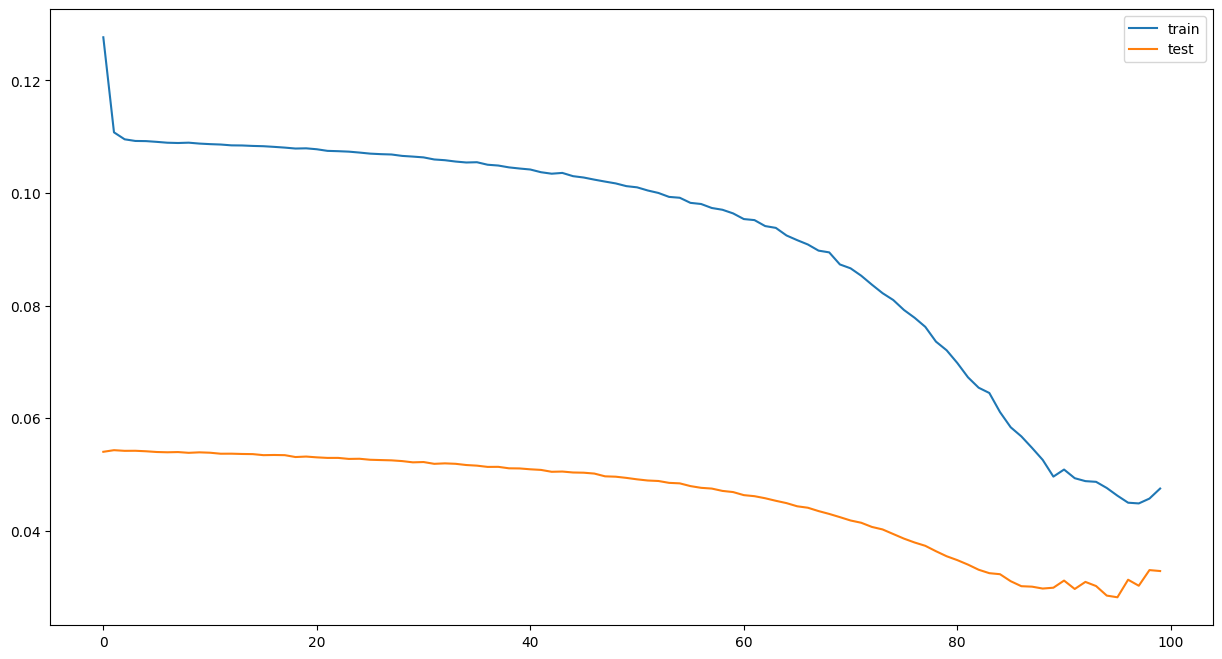

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [ ]:
# make a prediction
pred_y = model_Stacked_biDir_tune.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [ ]:
pred_y[:5]

array([[0.079395  , 0.08577871, 0.08109061, 0.07861838, 0.08881772],
       [0.08664052, 0.09175751, 0.08775245, 0.08508456, 0.09534375],
       [0.09444936, 0.09820893, 0.09496806, 0.09157684, 0.10191964],
       [0.09664409, 0.10009188, 0.09704131, 0.09398923, 0.10441032],
       [0.09332193, 0.09721914, 0.09389167, 0.09051308, 0.10085447]],
      dtype=float32)

In [ ]:
pred_y.shape

(232, 5)

## Resacling Prediction

In [ ]:
data_pred = test_data.copy()
for i in data_pred.columns:
  if i.startswith('target'):
    data_pred.drop(columns=i,inplace=True)

In [ ]:
for i in range(0,5):
  data_pred['prediction_t'+str(i+1)] = pred_y[:,i]

In [ ]:
data_pred

,quantity,min_price,max_price,modal_price,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.079395,0.085779,0.081091,0.078618,0.088818
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.086641,0.091758,0.087752,0.085085,0.095344
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.094449,0.098209,0.094968,0.091577,0.101920
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.096644,0.100092,0.097041,0.093989,0.104410
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.093322,0.097219,0.093892,0.090513,0.100854
...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.167691,0.159308,0.162697,0.151607,0.162695
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.199652,0.185705,0.192085,0.180797,0.192092
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.182406,0.171359,0.176258,0.165066,0.176416


In [ ]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [ ]:
# Display Predicted values
inv_pred_y[:2,]

array([[660.49097776, 697.51653671, 670.32551914, 655.98658919,
        715.14275074],
       [702.51502693, 732.19353557, 708.9642331 , 693.49047691,
        752.99377143]])

## Rescaling Actuals

In [ ]:
data_actual= test_data.copy()

In [ ]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [ ]:
# Display Actual target values
inv_test_y[:2,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.]])

## Comapring Actuals vs Predicted

In [ ]:
pred_df = pd.DataFrame(index=test_data.index)

In [ ]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]

In [ ]:
pred_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,660.490978,670.0,697.516537,730.0,670.325519,730.0,655.986589,470.0,715.142751
2022-07-24,670.0,702.515027,730.0,732.193536,730.0,708.964233,470.0,693.490477,530.0,752.993771
2022-07-25,730.0,747.806266,730.0,769.611818,470.0,750.814737,530.0,731.145698,600.0,791.133890
2022-07-26,730.0,760.535714,470.0,780.532916,530.0,762.839592,600.0,745.137538,670.0,805.579859
2022-07-27,470.0,741.267176,530.0,763.871008,600.0,744.571659,670.0,724.975866,670.0,784.955934
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,1172.608447,1200.0,1123.988050,1000.0,1143.639761,930.0,1079.319084,870.0,1143.628180
2023-03-10,1200.0,1357.983854,1000.0,1277.091369,930.0,1314.094976,870.0,1248.623958,930.0,1314.134386
2023-03-11,1000.0,1257.953811,930.0,1193.883252,870.0,1222.294140,930.0,1157.382390,730.0,1223.211300


In [ ]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [ ]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i])
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    0.183827
MAPE_2    0.189212
MAPE_3    0.215043
MAPE_4    0.197391
MAPE_5    0.248883
dtype: float64


In [ ]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'LSTM'}, inplace= True)
model_comparision

,LSTM
MAPE_1,0.183827
MAPE_2,0.189212
MAPE_3,0.215043
MAPE_4,0.197391
MAPE_5,0.248883


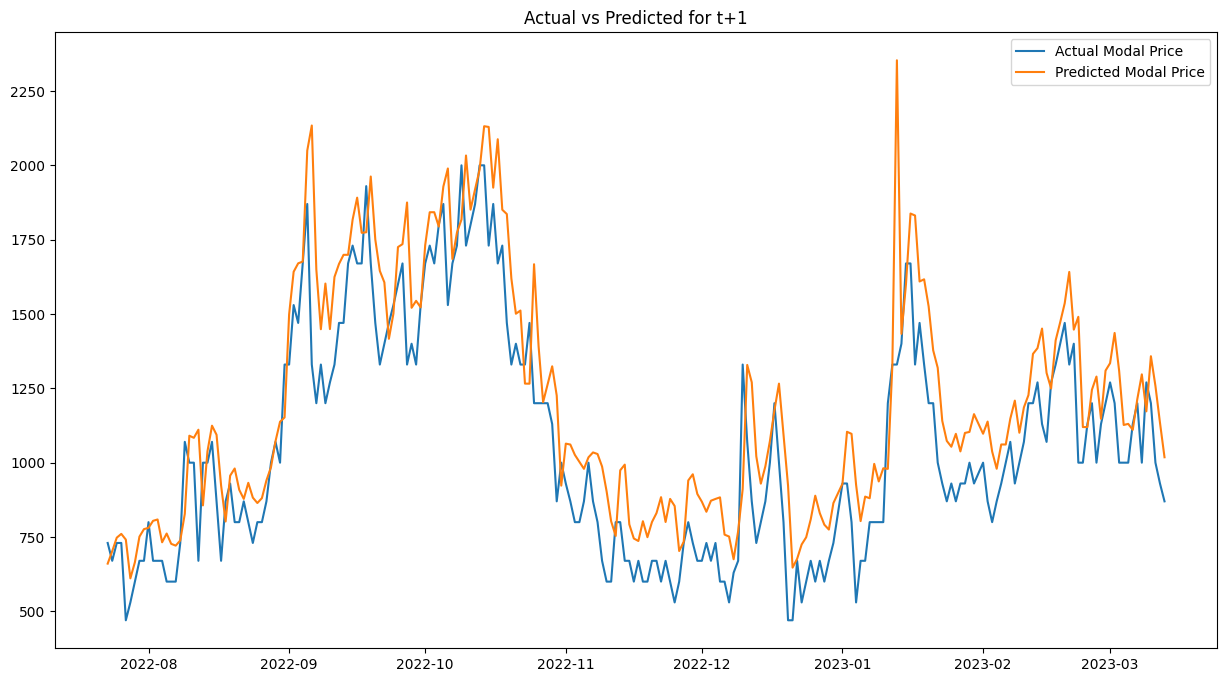

In [ ]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Comparing all models


In [ ]:
model_comparision

,LSTM
MAPE_1,0.153364
MAPE_2,0.170753
MAPE_3,0.197357
MAPE_4,0.198962
MAPE_5,0.209254
